In [37]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Sentinel-2 WOFS Product Creation**

### Config

Import required DC utils

In [38]:
import datacube
# DC utilities
#from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

#SAC utilities
from utils_sac.clean_mask import landsat_qa_clean_mask

Define aoi via wkt polygon (could be subbed or shapefile)

In [52]:
aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [53]:
dc = datacube.Datacube(app="na")

In [54]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [42]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.27, -18.25) 
Lon: (178.12, 178.15)


### Load Data

Generic query specs

In [55]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,12,15), datetime(2019,1,1)),
                resolution = (10,10))

Dataset-specifics

In [56]:
scenes = dc.load(product="s2_esa_sr_granule",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"],
               **query)

In [45]:
scenes['swir1']=scenes.swir_1
scenes['swir2']=scenes.swir_2
scenes = scenes.drop('swir_1')
scenes = scenes.drop('swir_2')

In [46]:
scenes

<xarray.Dataset>
Dimensions:               (time: 7, x: 107, y: 75)
Coordinates:
  * time                  (time) datetime64[ns] 2018-12-15T22:19:31 ... 2018-12-30T22:19:39
  * y                     (y) float64 7.98e+06 7.98e+06 ... 7.982e+06 7.982e+06
  * x                     (x) float64 6.184e+05 6.184e+05 ... 6.216e+05
Data variables:
    green                 (time, y, x) uint16 1707 1622 1536 ... 2486 2444 2413
    red                   (time, y, x) uint16 1589 1467 1408 ... 2258 2244 2190
    blue                  (time, y, x) uint16 1340 1286 1249 ... 2351 2342 2309
    nir                   (time, y, x) uint16 1268 1181 1085 ... 3122 3047 3030
    coastal_aerosol       (time, y, x) uint16 1398 1280 1280 ... 2757 2734 2734
    scene_classification  (time, y, x) uint8 6 6 6 6 6 6 6 6 ... 8 8 8 8 8 8 8 8
    swir1                 (time, y, x) uint16 2052 1737 1737 ... 1315 1303 1303
    swir2                 (time, y, x) uint16 880 845 760 703 ... 1988 1966 1954
Attributes:
    c

Check loaded

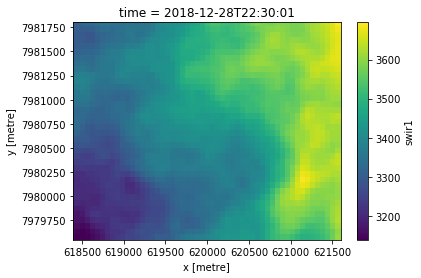

In [51]:
scenes.isel(time = 5).swir1.plot();

Create + apply 'cleansky' mask

In [48]:

clearsky_masks = landsat_qa_clean_mask(scenes, 'SENTINEL_2')
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [49]:
water_classes = wofs_classify(scenes, no_data = np.nan, x_coord='x', y_coord = "y")

Visualise wofs summary product

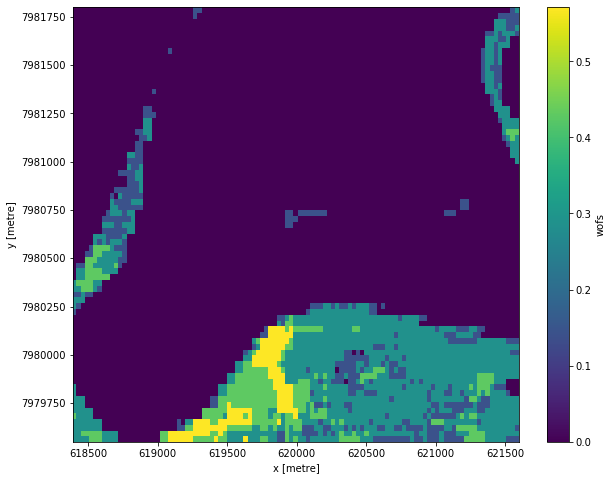

In [50]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()